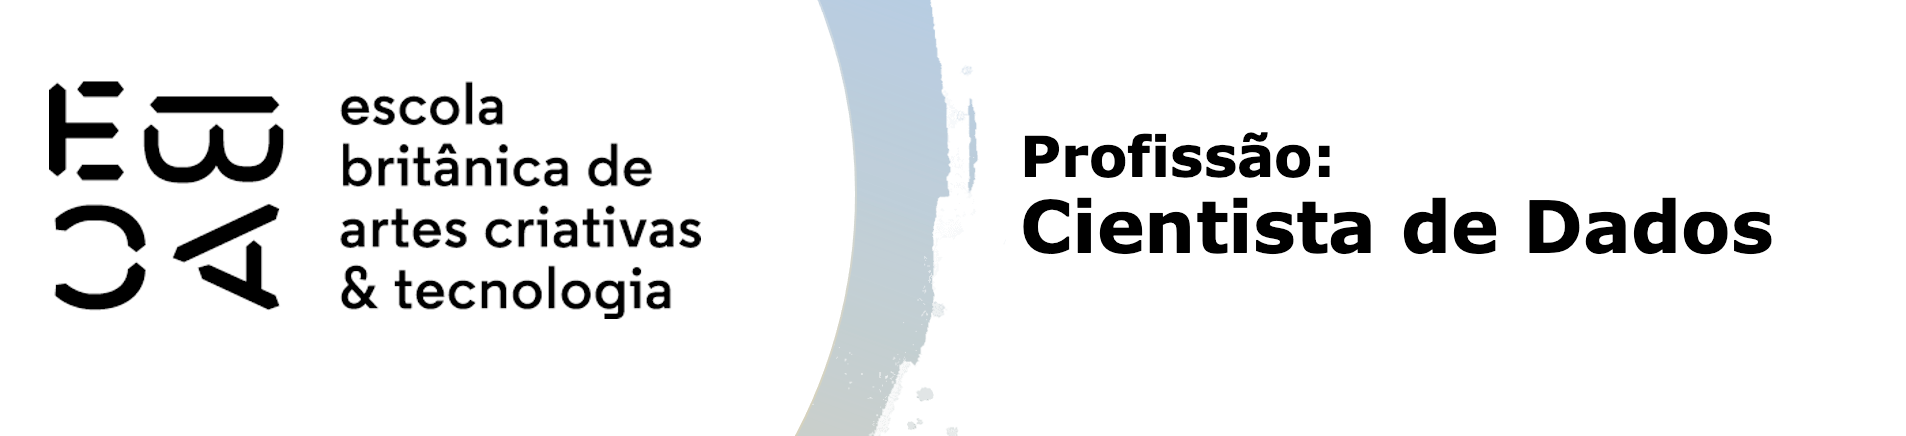

# Tarefa II

Ainda sobre a base da NFP vista na tarefa passada:

|Campo|Descrição|
|:-|:-|
|CNPJ emit.| CNPJ do emitente da nota|
|Emitente| Nome fantasia do emitente da nota|
|No.| Número da nota fiscal|
|Data Emissão| Data de emissão da nota fiscal|
|Valor NF| Valor da nota fiscal|
|Data Registro| Data de registro no sistema da NFP|
|Créditos| Valor dos créditos (doação)|
|Situação do Crédito| Se o crédito já foi pago, está sendo processado etc.|
|Ano| Ano da emissão da nota|
|Semestre| Semestre da emissão da nota|
|Retorno| Valor do crédito dividido pelo valor da nota|
|flag_credito| Indicadora se a nota possui crédito positivo|
|categoria| Categorização da nota |

**OBJETIVO:** Algumas notas não dão retorno, o que pode ocorrer por diversos motivos, um deles seria a ocorrência de produtos não incentivados como cigarros e bebidas alcólicas. O nosso objetivo é tentar prever que tipo de nota tem maior ou menor propensão a fornecer créditos.

**Observação**: Esta é uma base real, havendo características de acordo. Pode haver uma variabilidade difícil de explicar, em parte por causa de uma freqüência de notas inconstante no tempo (por diversos motivos), em parte por haverem informações importantes, protegidas pela LGPD, não constantes na base, que pode interferir no crédito gerado, o que vai ocasionar uma variabilidade difícil de se explicar. *Welcome to the jungle*, A vida real é assim :)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings;  

warnings.filterwarnings("ignore")

In [2]:
df = pd.read_pickle('base_nfp.pkl')
df_2020 = df[df['Ano']>= 2020]

df_2020.dropna(inplace=True)
df_2020.reset_index(inplace=True)
df_2020.head()

,index,CNPJ emit.,Emitente,No.,Data Emissão,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,Retorno,flag_credito,categoria
0,100702,64.963.044/0001-08,FARMACLUB DROGARIAS LTDA,3114110,2020-06-30,179.55,2020-06-30,0.0,Liberado,2020,1,0.0,0,Farmácia
1,100703,00.776.574/0022-80,B2W Companhia Digital,9344628,2020-06-30,63.38,2020-06-30,0.0,Liberado,2020,1,0.0,0,não definido
2,100704,13.986.197/0002-02,LOJA ELECTROLUX COM VIRTUAL DE ELET,387412,2020-06-30,396.41,2020-06-30,0.0,Liberado,2020,1,0.0,0,não definido
3,100705,61.585.865/0703-62,RAIADROGASIL S/A,8121,2020-06-30,53.90,2020-06-30,0.0,Liberado,2020,1,0.0,0,Farmácia
4,100706,15.436.940/0003-67,AMAZON SERVICOS DE VAREJO DO BRASIL LTDA,5889036,2020-06-30,32.90,2020-06-30,0.0,Liberado,2020,1,0.0,0,Varejo


## Criando variáveis

**Variáveis temporais**: É possível que haja alguma regra de liberação de créditos de acordo com o dia do mês, o dia da semana, fim de semana (sim ou não), ou até alterações temporais da regra. Vamos criar as seguintes variáveis para testar estas hipóteses:

- Dia da semana
- Dummy para fim de semana
- Dia do mês
- Mês (já na base)
- Trimestre
- Ano (já na base)

**Valor da nota**: Vamos criar também algumas variáveis para resumir o valor da nota, e posteriormente criar uma intuição sobre categorizações de variáveis contínuas.

- Crie categorizações da variável ```Valor NF```, por quantís, em 5, 10, 20 e 50 categorias.

In [3]:
df_2020['dia_de_semana'] = df_2020['Data Emissão'].dt.day_name()
df_2020['fim_de_semana'] = ((df_2020['Data Emissão'].dt.dayofweek) // 5 == 1).astype(float)
df_2020['dia_mes'] = df_2020['Data Emissão'].dt.day
df_2020['mes'] = df_2020['Data Emissão'].dt.month
df_2020['trimestre'] = df_2020['Data Emissão'].dt.quarter
df_2020['Ano'] = df_2020['Data Emissão'].dt.year
df_2020.head()

,index,CNPJ emit.,Emitente,No.,Data Emissão,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,Retorno,flag_credito,categoria,dia_de_semana,fim_de_semana,dia_mes,mes,trimestre
0,100702,64.963.044/0001-08,FARMACLUB DROGARIAS LTDA,3114110,2020-06-30,179.55,2020-06-30,0.0,Liberado,2020,1,0.0,0,Farmácia,Tuesday,0.0,30,6,2
1,100703,00.776.574/0022-80,B2W Companhia Digital,9344628,2020-06-30,63.38,2020-06-30,0.0,Liberado,2020,1,0.0,0,não definido,Tuesday,0.0,30,6,2
2,100704,13.986.197/0002-02,LOJA ELECTROLUX COM VIRTUAL DE ELET,387412,2020-06-30,396.41,2020-06-30,0.0,Liberado,2020,1,0.0,0,não definido,Tuesday,0.0,30,6,2
3,100705,61.585.865/0703-62,RAIADROGASIL S/A,8121,2020-06-30,53.90,2020-06-30,0.0,Liberado,2020,1,0.0,0,Farmácia,Tuesday,0.0,30,6,2
4,100706,15.436.940/0003-67,AMAZON SERVICOS DE VAREJO DO BRASIL LTDA,5889036,2020-06-30,32.90,2020-06-30,0.0,Liberado,2020,1,0.0,0,Varejo,Tuesday,0.0,30,6,2


In [28]:
df_2020['nf_5'] = pd.qcut(x=df_2020['Valor NF'], q=5, duplicates='drop')
df_2020['nf_10'] = pd.qcut(x=df_2020['Valor NF'], q=10, duplicates='drop')
df_2020['nf_20'] = pd.qcut(x=df_2020['Valor NF'], q=20, duplicates='drop')
df_2020['nf_50'] = pd.qcut(x=df_2020['Valor NF'], q=50, duplicates='drop')
df_2020.head()

,index,CNPJ emit.,Emitente,No.,Data Emissão,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,...,categoria,dia_de_semana,fim_de_semana,dia_mes,mes,trimestre,nf_5,nf_10,nf_20,nf_50
0,100702,64.963.044/0001-08,FARMACLUB DROGARIAS LTDA,3114110,2020-06-30,179.55,2020-06-30,0.0,Liberado,2020,...,Farmácia,Tuesday,0.0,30,6,2,"(92.32, 195.376]","(129.9, 195.376]","(156.9, 195.376]","(178.62, 195.376]"
1,100703,00.776.574/0022-80,B2W Companhia Digital,9344628,2020-06-30,63.38,2020-06-30,0.0,Liberado,2020,...,não definido,Tuesday,0.0,30,6,2,"(49.938, 92.32]","(49.938, 67.53]","(58.15, 67.53]","(63.28, 67.53]"
2,100704,13.986.197/0002-02,LOJA ELECTROLUX COM VIRTUAL DE ELET,387412,2020-06-30,396.41,2020-06-30,0.0,Liberado,2020,...,não definido,Tuesday,0.0,30,6,2,"(195.376, 562500.0]","(349.926, 562500.0]","(349.926, 557.975]","(349.926, 409.821]"
3,100705,61.585.865/0703-62,RAIADROGASIL S/A,8121,2020-06-30,53.90,2020-06-30,0.0,Liberado,2020,...,Farmácia,Tuesday,0.0,30,6,2,"(49.938, 92.32]","(49.938, 67.53]","(49.938, 58.15]","(52.8, 56.133]"
4,100706,15.436.940/0003-67,AMAZON SERVICOS DE VAREJO DO BRASIL LTDA,5889036,2020-06-30,32.90,2020-06-30,0.0,Liberado,2020,...,Varejo,Tuesday,0.0,30,6,2,"(25.0, 49.938]","(25.0, 36.26]","(30.38, 36.26]","(31.59, 33.98]"


## Calcule o IV de todas essas variáveis

Sugestão: Construa um metadados e tente utilizar uma função como a que foi utilizada durante a aula. Você vai conseguir fazer esse cálculo para as variáveis uma a uma, mas em casos reais em que vamos mais além na criação de variáveis, podemos ter centenas, ou até milhares de variáveis, esses cálculos *precisam* ser automáticos nesses casos.

In [5]:
df_2020.columns


Index(['index', 'CNPJ emit.', 'Emitente', 'No.', 'Data Emissão', 'Valor NF',
       'Data Registro', 'Créditos', 'Situação do Crédito', 'Ano', 'Semestre',
       'Retorno', 'flag_credito', 'categoria', 'dia_de_semana',
       'fim_de_semana', 'dia_mes', 'mes', 'trimestre', 'nf_5', 'nf_10',
       'nf_20', 'nf_50'],
      dtype='object')

In [6]:
df_2020_drop = df_2020.drop(columns=['index', 'CNPJ emit.', 'Emitente', 'No.', 'Data Emissão', 'Valor NF',
       'Data Registro', 'Créditos', 'Situação do Crédito', 'Retorno'])

metadados = pd.DataFrame({'dtype': df_2020_drop.dtypes})
metadados

,dtype
Ano,int32
Semestre,int64
flag_credito,int64
categoria,object
dia_de_semana,object
fim_de_semana,float64
dia_mes,int32
mes,int32
trimestre,int32
nf_5,category


In [7]:
# Atribuindo papéis
metadados['papel'] = 'covariavel'
metadados.loc['flag_credito','papel'] = 'resposta'
metadados['nunique'] = df_2020_drop.nunique()
metadados

,dtype,papel,nunique
Ano,int32,covariavel,2
Semestre,int64,covariavel,2
flag_credito,int64,resposta,2
categoria,object,covariavel,9
dia_de_semana,object,covariavel,7
fim_de_semana,float64,covariavel,2
dia_mes,int32,covariavel,31
mes,int32,covariavel,12
trimestre,int32,covariavel,4
nf_5,category,covariavel,5


In [9]:
# Definindo a função
def IV(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    rótulo_evento = tab.columns[0]
    rótulo_nao_evento = tab.columns[1]

    tab['pct_evento'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    tab['pct_nao_evento'] = tab[rótulo_nao_evento]/tab.loc['total',rótulo_nao_evento]
    tab['woe'] = np.log(tab['pct_evento'] / tab['pct_nao_evento'].replace(0, np.nan))
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
   
    return tab['iv_parcial'].sum()


In [10]:
for var in df_2020_drop.columns:
    if var != 'flag_credito':
        try:
            iv_value = IV(df_2020_drop[var], df_2020_drop['flag_credito'])
            metadados.loc[var, 'IV'] = iv_value
        except Exception as e:
            print(f"Erro ao calcular IV para {var}: {e}")

# Exibindo os metadados com IV calculado
metadados[['IV']]

,IV
Ano,0.002564
Semestre,0.003708
flag_credito,NaN
categoria,0.241196
dia_de_semana,0.006774
fim_de_semana,0.005290
dia_mes,0.012543
mes,0.007882
trimestre,0.003033
nf_5,0.044803


In [11]:
metadados.loc[metadados['IV'] >= 0, 'poder_preditivo'] = 'Inútil'
metadados.loc[(metadados['IV'] > 0.02) & (metadados['IV'] <= 0.1), 'poder_preditivo'] = 'Fraco'
metadados.loc[(metadados['IV'] > 0.1) & (metadados['IV'] <= 0.3), 'poder_preditivo'] = 'Médio'
metadados.loc[(metadados['IV'] > 0.3) & (metadados['IV'] <= 0.5), 'poder_preditivo'] = 'Forte'
metadados.loc[(metadados['IV'] > 0.5), 'poder_preditivo'] = 'Super alto'

metadados

,dtype,papel,nunique,IV,poder_preditivo
Ano,int32,covariavel,2,0.002564,Inútil
Semestre,int64,covariavel,2,0.003708,Inútil
flag_credito,int64,resposta,2,NaN,NaN
categoria,object,covariavel,9,0.241196,Médio
dia_de_semana,object,covariavel,7,0.006774,Inútil
fim_de_semana,float64,covariavel,2,0.005290,Inútil
dia_mes,int32,covariavel,31,0.012543,Inútil
mes,int32,covariavel,12,0.007882,Inútil
trimestre,int32,covariavel,4,0.003033,Inútil
nf_5,category,covariavel,5,0.044803,Fraco


## Conclua

- Quais variáveis parecem apresentar maior poder de discriminação segundo o IV?
- Quando categorizamos variáveis contínuas parece haver alguma relação entre o número de categorias e o IV?

>Segundo a análise acima, a variável que apresenta o maior poder de discriminação é a categoria. Quanto maior o nível da categoria maior o IV. 

## Descritiva simples no tempo

Para compor a análise que virá a seguir, faça uma análise descritiva básica no tempo - utilize trimestre como agregação (ou uma média móvel por trimestre, como preferir) e avalie graficamente:

- A quantidade de notas registradas na base por período
- A quantidade de notas por categoria e por período
- A proporção de notas com crédito por categoria por período

In [12]:
df_2020_tri = df_2020.groupby(['trimestre', 'flag_credito']).size().unstack(fill_value=0)
df_2020_tri['soma'] = df_2020_tri.sum(axis=1)
df_2020_tri

flag_credito,0,1,soma
trimestre,,,
1,11385,9146,20531
2,11847,8231,20078
3,12377,9720,22097
4,13061,10221,23282


In [13]:
tab = df_2020.groupby(['trimestre', 'flag_credito']).size().unstack(fill_value=0)
tab['N'] = tab.sum(axis=1)
tab['tx_evento'] = df_2020_tri[1]/df_2020_tri[0]
tab.reset_index()
tab

flag_credito,0,1,N,tx_evento
trimestre,,,,
1,11385,9146,20531,0.803338
2,11847,8231,20078,0.694775
3,12377,9720,22097,0.785328
4,13061,10221,23282,0.782559


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


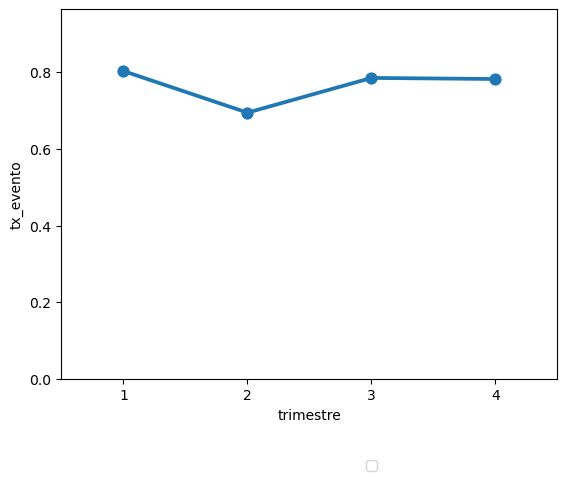

In [25]:
fig, ax = plt.subplots()

sns.pointplot(data=tab.reset_index(), x='trimestre', y='tx_evento', ci=None, ax=ax)
ax.set_ylim([0, tab.tx_evento.max()*1.2]);

ax.legend(bbox_to_anchor=(.65, -.2), ncol=2)

<Axes: xlabel='trimestre', ylabel='soma'>

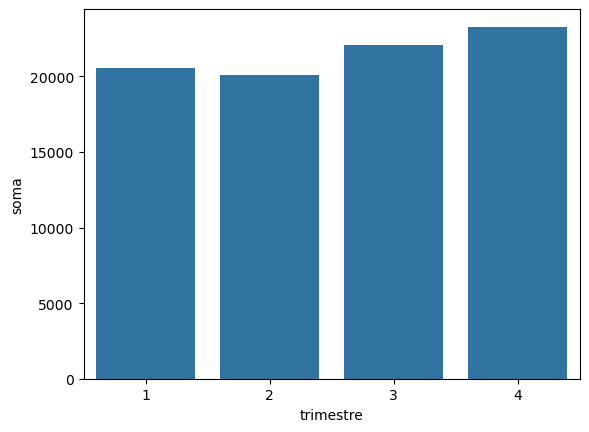

In [15]:
fig, ax = plt.subplots()

sns.barplot(data=df_2020_tri.reset_index(), x='trimestre', y='soma', ci=None, ax=ax)

In [16]:
df_2020_cat3 = df_2020.groupby(['trimestre', 'categoria', 'flag_credito']).size().unstack(fill_value=0)
df_2020_cat3['soma'] = df_2020_cat3.sum(axis=1)
df_2020_cat3['tx_evento'] = df_2020_cat3[1]/df_2020_cat3[0]
df_2020_cat3.head()

flag_credito             0     1  soma  tx_evento
trimestre categoria                              
1         Alimentos    371   908  1279   2.447439
          Auto posto   117    34   151   0.290598
          Construção  2040  1811  3851   0.887745
          Farmácia    1791   638  2429   0.356226
          Mercado     3454  3271  6725   0.947018

<Axes: xlabel='categoria', ylabel='soma'>

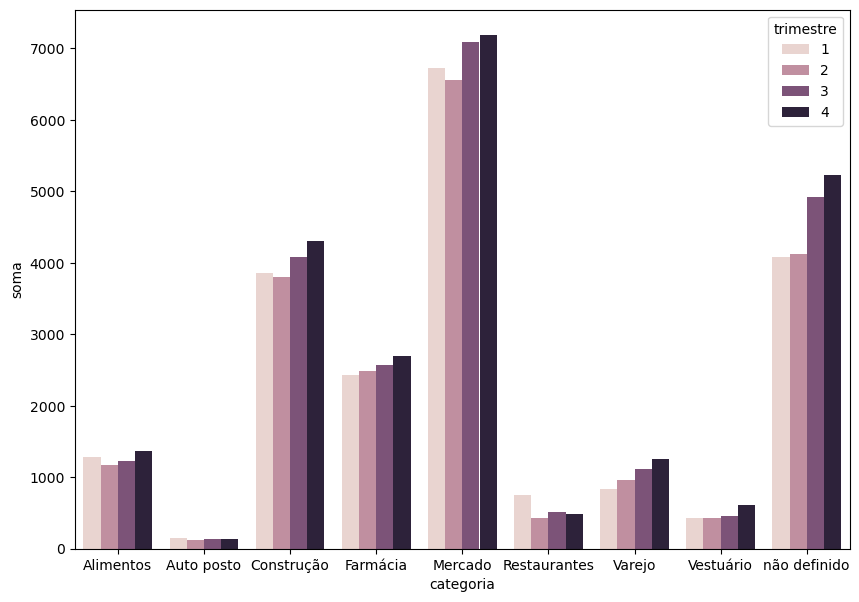

In [17]:
fig, ax = plt.subplots(figsize=(10, 7))

sns.barplot(data=df_2020_cat3.reset_index(), x='categoria',y='soma', hue='trimestre', ci=None, ax=ax)

<Axes: xlabel='categoria', ylabel='tx_evento'>

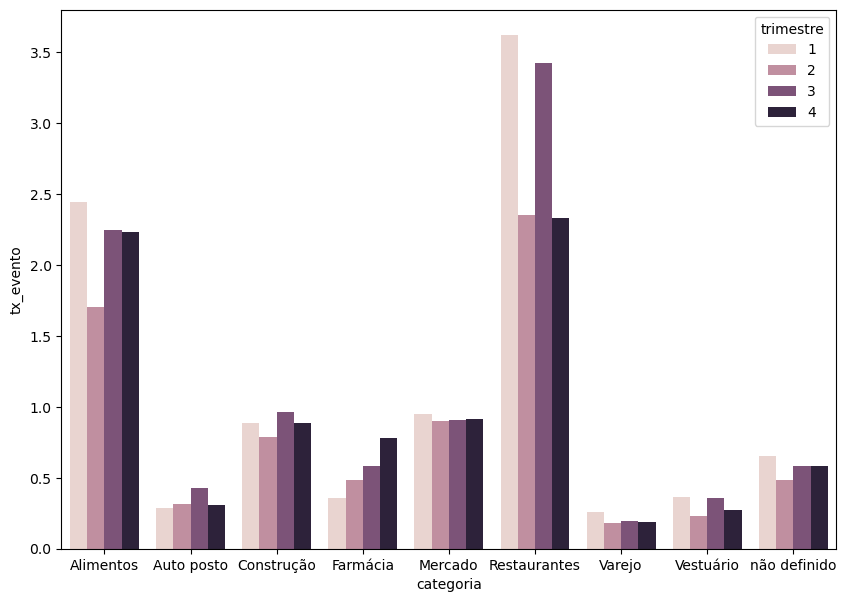

In [18]:
fig, ax = plt.subplots(figsize=(10,7))

sns.barplot(data=df_2020_cat3.reset_index(), x='categoria', y='tx_evento', hue = 'trimestre', ci=None, ax=ax)

## Avalie o WOE e o IV no tempo

Avalie o WOE e o IV no tempo da variável ```categoria```.

In [30]:
df_2020_cat3['pct_evento'] = df_2020_cat3[1]/df_2020_cat3[1].groupby(level=0).sum()
df_2020_cat3['pct_nao_evento'] = df_2020_cat3[0]/df_2020_cat3[0].groupby(level=0).sum()
df_2020_cat3['WOE'] = np.log(df_2020_cat3.pct_evento/df_2020_cat3.pct_nao_evento)
df_2020_cat3.head()

flag_credito             0     1  soma  tx_evento  pct_evento  pct_nao_evento  \
trimestre categoria                                                             
1         Alimentos    371   908  1279   2.447439    0.099278        0.032587   
          Auto posto   117    34   151   0.290598    0.003717        0.010277   
          Construção  2040  1811  3851   0.887745    0.198010        0.179183   
          Farmácia    1791   638  2429   0.356226    0.069757        0.157312   
          Mercado     3454  3271  6725   0.947018    0.357643        0.303382   

flag_credito               WOE  
trimestre categoria             
1         Alimentos   1.114022  
          Auto posto -1.016833  
          Construção  0.099909  
          Farmácia   -0.813211  
          Mercado     0.164543

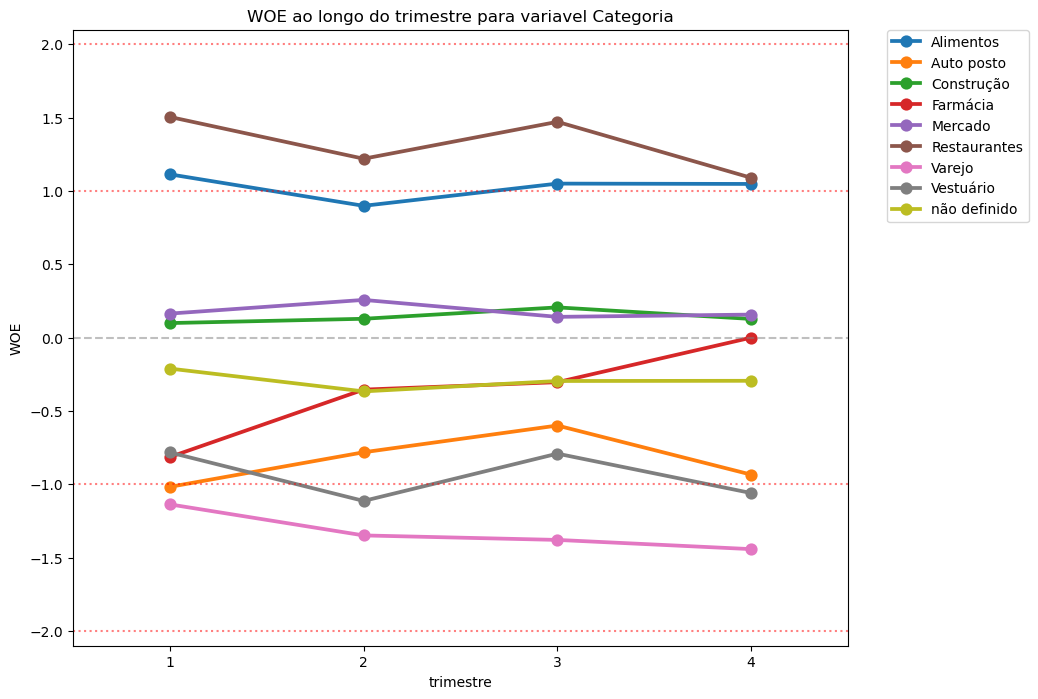

In [31]:
fig, ax = plt.subplots(figsize=(10,8))
variavel = 'categoria'

sns.pointplot(data=df_2020_cat3.reset_index(), y='WOE', x='trimestre', hue=variavel, ax=ax)

# limites do gráfico - mostrando 1 e -1 para ter referência
ymax = max(2.1, max(df_2020_cat3.WOE))
ymin = min(-2.1, min(df_2020_cat3.WOE))
ax.set_ylim([ymin, ymax])

# Linhas de referência
ax.axhline(2, linestyle=':', color='red', alpha=.5)
ax.axhline(1, linestyle=':', color='red', alpha=.5)
ax.axhline(0, linestyle='--', color='grey', alpha=.5)
ax.axhline(-1, linestyle=':', color='red', alpha=.5)
ax.axhline(-2, linestyle=':', color='red', alpha=.5)

# Títulos
ax.set_title(f'WOE ao longo do trimestre para variavel {variavel.capitalize()}')
plt. legend (bbox_to_anchor=( 1.05 , 1 ), loc="upper left", borderaxespad= 0 ) 

<Axes: xlabel='trimestre'>

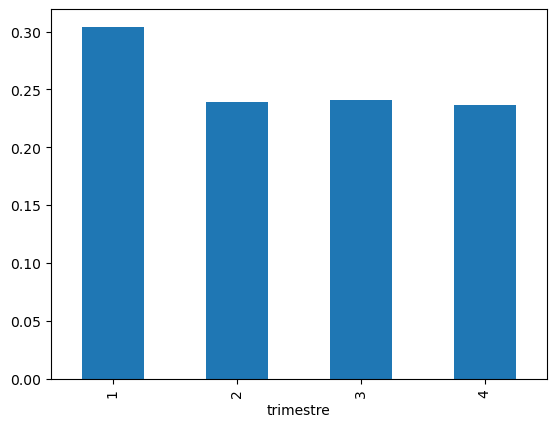

In [32]:
iv_trimestre = ((df_2020_cat3.pct_evento - df_2020_cat3.pct_nao_evento)*df_2020_cat3.WOE).groupby(level=0).sum()
iv_trimestre.plot.bar()

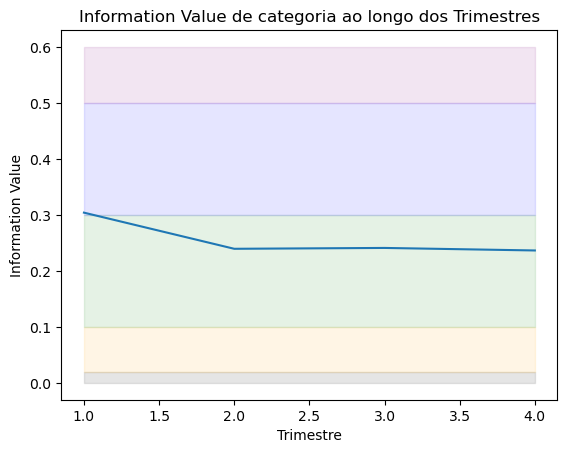

In [34]:
def plot_iv(IV):
    fig, ax = plt.subplots()
    x = IV.index
    a = [.02]*len(IV.index)
    b = [.1]*len(IV.index)
    c = [.3]*len(IV.index)
    d = [.5]*len(IV.index)
    e = [.6]*len(IV.index)

    ax.fill_between(IV.index, a, color='grey', alpha=.2)
    ax.fill_between(IV.index, a, b, color='orange', alpha=.1)
    ax.fill_between(IV.index, b, c, color='green', alpha=.1)
    ax.fill_between(IV.index, c, d, color='blue', alpha=.1)
    ax.fill_between(IV.index, d, e, color='purple', alpha=.1)
    ax.plot(IV)

    ax.set_title("Information Value de categoria ao longo dos Trimestres")
    ax.set_ylabel("Information Value")
    ax.set_xlabel("Trimestre")
    
plot_iv(iv_trimestre)

## Conclua

- Quais categorias parece ter maior proporção de notas com retornos maiores que zero?
- Essas diferenças são estáveis no tempo?

Dicas:<br>
- Considere que a quantidade de notas vem aumentando
- Considere que há períodos bem atípicos no histórico
- Considere que a partir de janeiro de 2020 o público é mais parecido com o público atual (2022), seja por pandemia, seja por crescimento do público, e considere os dados dessa data em diante na sua conclusão.

>Podemos concluir que os alimentos apresentam a maior proporção de retornos positivos. Aparentemente merercado e construção apresetam maio estabilidade ao longo do tempo. E farmácia apresentou um aumento considerável no WOE.